In [1]:
import argparse

import torch
import torch.backends.cudnn as cudnn
import numpy as np
import PIL.Image as pil_image

from models import RDN
from utils import convert_rgb_to_y, denormalize, calc_psnr

In [52]:
weights_file = "weigths/rdn_x4.pth"
num_features = 64
growth_rate = 64
num_blocks = 16
num_layers = 8
scale = 4

In [53]:
cudnn.benchmark = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [54]:
model = RDN(scale_factor=scale,
            num_channels=3,
            num_features=num_features,
            growth_rate=growth_rate,
            num_blocks=num_blocks,
            num_layers=num_layers).to(device)

In [55]:
state_dict = model.state_dict()
for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)

In [56]:
model.eval()

RDN(
  (sfe1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sfe2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rdbs): ModuleList(
    (0): RDB(
      (layers): Sequential(
        (0): DenseLayer(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
        )
        (1): DenseLayer(
          (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
        )
        (2): DenseLayer(
          (conv): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
        )
        (3): DenseLayer(
          (conv): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
        )
        (4): DenseLayer(
          (conv): Conv2d(320, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
      

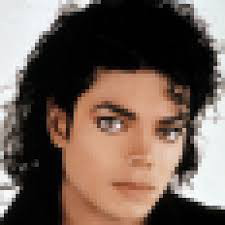

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_22508\4207095510.py:8: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  hr = image.resize((image_width, image_height), resample=pil_image.BICUBIC)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_22508\4207095510.py:9: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  lr = hr.resize((hr.width // scale, hr.height // scale), resample=pil_image.BICUBIC)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_22508\4207095510.py:10: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  bicubic = lr.resize((lr.width * scale, lr.height * scale), resample=pil_image.BICUBIC)


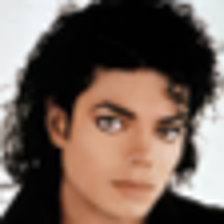

In [57]:
image_file = "data/jackson.png"
image = pil_image.open(image_file).convert('RGB')

image_width = (image.width // scale) * scale
image_height = (image.height // scale) * scale

display(image)
hr = image.resize((image_width, image_height), resample=pil_image.BICUBIC)
lr = hr.resize((hr.width // scale, hr.height // scale), resample=pil_image.BICUBIC)
bicubic = lr.resize((lr.width * scale, lr.height * scale), resample=pil_image.BICUBIC)

display(bicubic)
lr = np.expand_dims(np.array(lr).astype(np.float32).transpose([2, 0, 1]), 0) / 255.0
hr = np.expand_dims(np.array(hr).astype(np.float32).transpose([2, 0, 1]), 0) / 255.0
lr = torch.from_numpy(lr).to(device)
hr = torch.from_numpy(hr).to(device)

PSNR: 28.50


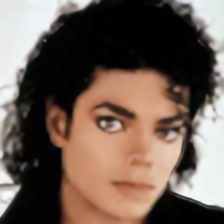

In [58]:
with torch.no_grad():
    preds = model(lr).squeeze(0)

preds_y = convert_rgb_to_y(denormalize(preds), dim_order='chw')
hr_y = convert_rgb_to_y(denormalize(hr.squeeze(0)), dim_order='chw')

preds_y = preds_y[scale:-scale, scale:-scale]
hr_y = hr_y[scale:-scale, scale:-scale]

psnr = calc_psnr(hr_y, preds_y)
print('PSNR: {:.2f}'.format(psnr))

output = pil_image.fromarray(denormalize(preds).permute(1, 2, 0).byte().cpu().numpy())
output.save(image_file.replace('.', '_rdn_x{}.'.format(scale)))
display(output)

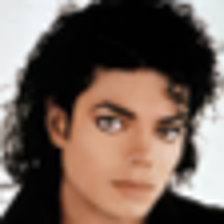

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_22508\1314197502.py:8: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  image_tab = image.resize((image_width, image_height), resample=pil_image.BICUBIC)


In [59]:
image_file = "data/jackson.png"
image = pil_image.open(image_file).convert('RGB')
image = bicubic
display(image)
image_width = (image.width // scale) * scale
image_height = (image.height // scale) * scale

image_tab = image.resize((image_width, image_height), resample=pil_image.BICUBIC)
image_tab = np.expand_dims(np.array(image_tab).astype(np.float32).transpose([2, 0, 1]), 0) / 255.0
image_tab = torch.from_numpy(image_tab).to(device)

In [46]:
with torch.no_grad():
    preds = model(image_tab).squeeze(0)

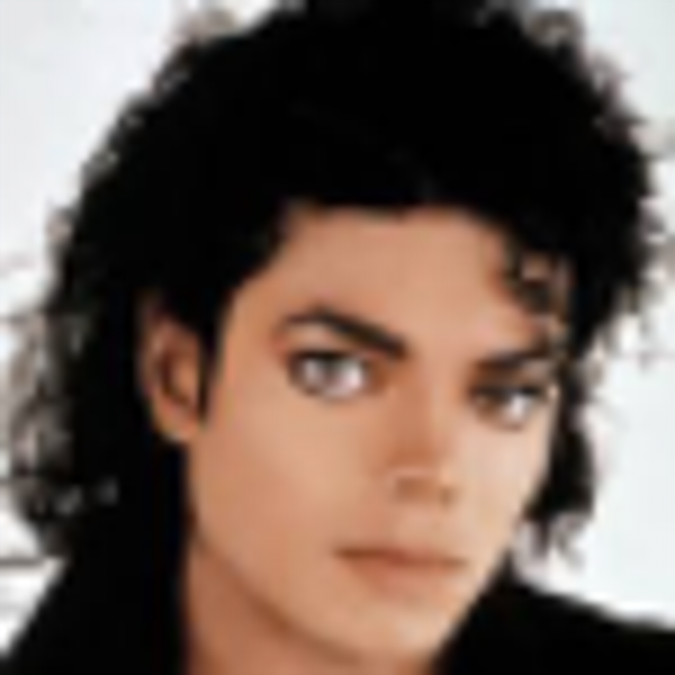

In [47]:
output = pil_image.fromarray(denormalize(preds).permute(1, 2, 0).byte().cpu().numpy())
#output = output.resize((image_width, image_height), resample=pil_image.BICUBIC)
display(output)